# 4 Convolutional Neural Networks - Medical Image Segmentation (TensorFlow)

This tutorial is solving a real-world problem in segmenting anatomical organs in 3D medical images, an argubly most successful area deep-learning has been applied to.

## 4.1 Image and Label Data

The images and labels (segmentations) in [PROMISE12][promise12] are used here. Download a copy of resampeld data by cloning the following repository:


[promise12]: https://promise12.grand-challenge.org/


In [1]:
#!git clone https://github.com/YipengHu/promise12.git

path_to_data = "./promise12"

Cloning into 'promise12'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 132 (delta 46), reused 132 (delta 46), pack-reused 0
Receiving objects: 100% (132/132), 55.30 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (46/46), done.


The *path_to_data* shoud contain all the data needed. If _git_ is not available as a system command (e.g. on Windows), the same data can also be downloaded here:

[Download Data][data_link]. 

In this case, the *path_to_data* needs to be specified to where the data are unzipped. For those who are interested, the script [*script_promise12*][script_promise12.py] has the code that resampled the original data. 


[data_link]: https://github.com/YipengHu/promise12/archive/data.zip
[script_promise12.py]: ./data/script_promise12.py

Now, check a few images and labels in the folder:

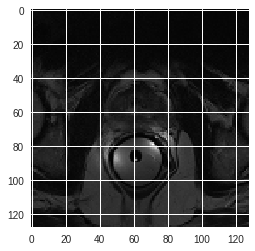

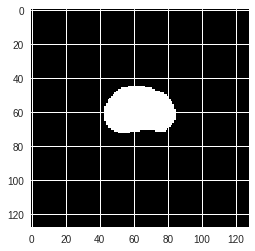

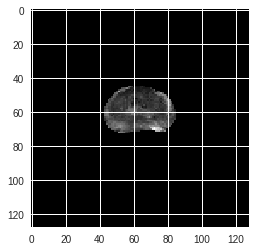

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


# load a training image-label pair
idx = 49
image = np.load(os.path.join(path_to_data, "image_train%02d.npy" % idx))
label = np.load(os.path.join(path_to_data, "label_train%02d.npy" % idx))
size_data = list(image.shape)

# plot the pair
idx_slice = 16
plt.figure()
plt.imshow(image[idx_slice,:,:], cmap='gray')
plt.figure()
plt.imshow(label[idx_slice,:,:], cmap='gray')

# and check to see if the mask is actually segmenting the ROI
plt.figure()
plt.imshow(image[idx_slice,:,:] * label[idx_slice,:,:], cmap='gray')

### Data feeding
For convinience, a very simple class for data feeding is loaded:

In [0]:
# a simple npy image reading class
class DataReader:

    def __init__(self, folder_name):
        self.folder_name = folder_name

    def load_images_train(self, indices_mb):
        return self.load_npy_files(["image_train%02d.npy" % idx for idx in indices_mb])

    def load_images_test(self, indices_mb):
        return self.load_npy_files(["image_test%02d.npy" % idx for idx in indices_mb])

    def load_labels_train(self, indices_mb):
        return self.load_npy_files(["label_train%02d.npy" % idx for idx in indices_mb])

    def load_npy_files(self, file_names):
        images = [np.float32(np.load(os.path.join(self.folder_name, fn))) for fn in file_names]
        return np.expand_dims(np.stack(images, axis=0), axis=4)

## 4.2 Computation Graph for a Fully Convolutional Neural Network
The following script is not optimised for performace or best coding practice. This illustrates a basic working workflow to do image segmentation.

### 4.2.1 Placeholders
Again, this is a special feature in TensorFlow to facilitate runtime data feeding. This will become clear later.

In [4]:
import tensorflow as tf

tf.ConfigProto()

In [5]:
import tensorflow as tf


# --- First define placeholders with fixed sizes
size_minibatch = 4  # number of images as one input minibatch
# only the gray-scale intensity values as one-channel feature, hence [1]:
ph_image = tf.placeholder(tf.float32, [size_minibatch]+size_data+[1])
ph_label = tf.placeholder(tf.float32, [size_minibatch]+size_data+[1])

# ph_image is 4 (4 images) x 32 (slices) x 128 x 128 (voxel per slice) x 1 (single gray-scale channel)
print(ph_image)

Tensor("Placeholder:0", shape=(4, 32, 128, 128, 1), dtype=float32)


### 4.2.2 Encoder-decoder network
This is a simplified imlementatin of an encoder-decoder network for image segmentation, similar to [U-Net][unet_paper].

[unet_paper]: https://arxiv.org/abs/1505.04597

We first halve image size so this can be reasonably tested, e.g. on a CPU. and usually, there is a data pre-processing (augmentation) layer in this place:

In [6]:
input_image = ph_image[:, ::2, ::2, ::2, :] # only choose every second slice and voxel/pixel
input_label = ph_label[:, ::2, ::2, ::2, :]
input_image

<tf.Tensor 'strided_slice:0' shape=(4, 16, 64, 64, 1) dtype=float32>

#### Step 1 - declare variables for storing convolution kernel "weights" to optimise

In [7]:
k_conv = [3, 3, 3]  # convolution kernel size
nc1 = 8  # number of feature maps after the convolution layer, i.e. channels
W1 = tf.get_variable("W1", shape=k_conv+[1, nc1], initializer=tf.contrib.layers.xavier_initializer())

W1


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


<tf.Variable 'W1:0' shape=(3, 3, 3, 1, 8) dtype=float32_ref>

#### Step 2 - include the following in a "convolution layer":
- (a) 3d convolution with padded feature maps (for convenience in working out the sizes at different resolution levels)
- (b) batch normalisation, and
- (c) nonlinear activation (relu in this case) ***??? rectified linear unit = nonlinear?***
- (d) pooling layer

In [0]:
strides_one = [1, 1, 1, 1, 1]  # stride of the sliding window used in convolution
layer1c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(input_image, W1, strides_one, padding="SAME")))
k_pool = [1, 2, 2, 2, 1]  # kernel for pooling
layer1 = tf.nn.max_pool3d(layer1c, k_pool, strides_one, "SAME")



In [9]:
# checking output
print(layer1c,layer1)
print(input_image)

Tensor("Relu:0", shape=(4, 16, 64, 64, 8), dtype=float32) Tensor("MaxPool3D:0", shape=(4, 16, 64, 64, 8), dtype=float32)
Tensor("strided_slice:0", shape=(4, 16, 64, 64, 1), dtype=float32)


#### Step3 - add a down-sampling convolution layers

In [0]:
nc2 = nc1*2  # double the number of feature maps
W2 = tf.get_variable("W2", shape=k_conv+[nc1, nc2], initializer=tf.contrib.layers.xavier_initializer())
layer2c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer1, W2, strides_one, "SAME")))
# down-sample via pooling layer
strides_two = [1, 2, 2, 2, 1]  # stride used for down-sampling and up-sampling
layer2 = tf.nn.max_pool3d(layer2c, k_pool, strides_two, "SAME")

In [11]:
# checking output
print(layer2c,layer2)

Tensor("Relu_1:0", shape=(4, 16, 64, 64, 16), dtype=float32) Tensor("MaxPool3D_1:0", shape=(4, 8, 32, 32, 16), dtype=float32)


#### Step4 - add two more of these down-sampling blocks

In [0]:
nc3 = nc2*2
W3 = tf.get_variable("W3", shape=k_conv+[nc2, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer3c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2, W3, strides_one, "SAME")))
layer3 = tf.nn.max_pool3d(layer3c, k_pool, strides_two, "SAME")

nc4 = nc3*2
W4 = tf.get_variable("W4", shape=k_conv+[nc3, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer4c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer3, W4, strides_one, "SAME")))
layer4 = tf.nn.max_pool3d(layer4c, k_pool, strides_two, "SAME")

In [13]:
# checking output
print("layer3: ",layer3c,layer3)
print("layer4: ",layer4c,layer4)


layer3:  Tensor("Relu_2:0", shape=(4, 8, 32, 32, 32), dtype=float32) Tensor("MaxPool3D_2:0", shape=(4, 4, 16, 16, 32), dtype=float32)
layer4:  Tensor("Relu_3:0", shape=(4, 4, 16, 16, 64), dtype=float32) Tensor("MaxPool3D_3:0", shape=(4, 2, 8, 8, 64), dtype=float32)


#### Step5 - add a convolution layer without sampling/pooling at the end of down-sampling blocks (i.e. the "encoder")

In [0]:
nc5 = nc4*2
W5 = tf.get_variable("W5", shape=k_conv+[nc4, nc5], initializer=tf.contrib.layers.xavier_initializer())
layer5 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer4, W5, strides_one, "SAME")))

In [15]:
# checking output
print("layer5: ",layer5, W5)

layer5:  Tensor("Relu_4:0", shape=(4, 2, 8, 8, 128), dtype=float32) <tf.Variable 'W5:0' shape=(3, 3, 3, 64, 128) dtype=float32_ref>


#### Step6 - add an up-sampling block (starting the "decoder"), with
- (a) the number of feature maps are halved;
- (b) use transpose convolution for up-sampling;
- (c) make sure the output size is the same as that of layer4c so they can be added (or concatenated)

In [0]:
W4d = tf.get_variable("W4d", shape=k_conv+[nc4, nc5], initializer=tf.contrib.layers.xavier_initializer())
layer4d = tf.nn.conv3d_transpose(layer5, W4d, output_shape=layer4c.get_shape(), strides=strides_two, padding="SAME")
# (d) add a skip layer (shortcut connection) to the encoder using summation
# (e) then add another convolution, batch normalisation and nonlinear activation
W4dc = tf.get_variable("W4dc", shape=k_conv+[nc4, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer4dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer4d+layer4c, W4dc, strides_one, "SAME")))

In [17]:
# checking output
print("layer4d: ",layer4d, layer4dc)

layer4d:  Tensor("conv3d_transpose:0", shape=(4, 4, 16, 16, 64), dtype=float32) Tensor("Relu_5:0", shape=(4, 4, 16, 16, 64), dtype=float32)


#### Step7 - # add another two of these up-sampling blocks
- the final layer should match the original input image size, in order to represent binary segmentation.

In [0]:
W3d = tf.get_variable("W3d", shape=k_conv+[nc3, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer3d = tf.nn.conv3d_transpose(layer4dc, W3d, layer3c.get_shape(), strides_two, "SAME")
W3dc = tf.get_variable("W3dc", shape=k_conv+[nc3, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer3dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer3d+layer3c, W3dc, strides_one, "SAME")))

W2d = tf.get_variable("W2d", shape=k_conv+[nc2, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer2d = tf.nn.conv3d_transpose(layer3dc, W2d, layer2c.get_shape(), strides_two, "SAME")
W2dc = tf.get_variable("W2dc", shape=k_conv+[nc2, nc2], initializer=tf.contrib.layers.xavier_initializer())
layer2dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2d+layer2c, W2dc, strides_one, "SAME")))

In [19]:
# checking output
print("layer3d: ",layer3d, layer3dc)
print("layer2d: ",layer2d, layer2dc)

layer3d:  Tensor("conv3d_transpose_1:0", shape=(4, 8, 32, 32, 32), dtype=float32) Tensor("Relu_6:0", shape=(4, 8, 32, 32, 32), dtype=float32)
layer2d:  Tensor("conv3d_transpose_2:0", shape=(4, 16, 64, 64, 16), dtype=float32) Tensor("Relu_7:0", shape=(4, 16, 64, 64, 16), dtype=float32)


#### Step8 - add a "read-out" layer with a sigmoid activation
- this is to represent the class probabilities;
- segmentation can be represented by two classes, forground class (prostate gland) and background class;
- or, by just one foreground class, commonly used for many loss functions other than cross entropy;
- check if output size is expected: *print(layer1d)*

In [0]:
# use single channel for soft Dice loss
W1d = tf.get_variable("W_out", shape=k_conv+[nc2, 1], initializer=tf.contrib.layers.xavier_initializer())
layer1d = tf.sigmoid(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2dc, W1d, strides_one, "SAME")))


In [21]:
print("layer1d: ",layer1d)

layer1d:  Tensor("Sigmoid:0", shape=(4, 16, 64, 64, 1), dtype=float32)


### 4.2.3 Loss for image segmentation
Cross-entropy can be used to treat segmentation as a voxel classification problem. Probabilitic (soft) Dice is also widely used.

In [0]:
# loss based on Dice, between predicted segmentation layer_out and ground-truth label
dice_numerator = tf.reduce_sum(layer1d*input_label, axis=[1, 2, 3, 4]) * 2
# adding a small value for numerical stability
dice_denominator = tf.reduce_sum(input_label, axis=[1, 2, 3, 4]) + tf.reduce_sum(layer1d, axis=[1, 2, 3, 4])+1e-6
dice = dice_numerator / dice_denominator
loss = 1 - tf.reduce_mean(dice)

In [23]:
# check output, dice is 4 because of 4 images individually?
print(dice_numerator,dice,loss)

Tensor("mul_1:0", shape=(4,), dtype=float32) Tensor("truediv:0", shape=(4,), dtype=float32) Tensor("sub:0", shape=(), dtype=float32)


### 4.2.4 Optimiser
Build a training op to specify the numerical optimisation algorithm.

In [24]:
train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

Instructions for updating:
Use tf.cast instead.


## 4.3 Set Up the Session

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
total_iter = int(1e5)+1 #int(1.1e4) # int(1e5)
n = 50  # 50 training image-label pairs
num_minibatch = int(n/size_minibatch)  # how many minibatches in each epoch
indices_train = [i for i in range(n)]
# data reader
DataFeeder = DataReader(path_to_data)

In [26]:
# check output
print(num_minibatch)

12


## 4.4 Train with Minibatch Optimisation
- Shuffle data every epoch
- Feed one minibatch of the data in each iteration
- Print training information
- Test during training

In [0]:
import random


# start the optimisation
for step in range(total_iter):

    # shuffle data every time start a new set of minibatches
    if step in range(0, total_iter, num_minibatch):
        random.shuffle(indices_train)

    # arrange data indices for a minibatch
    minibatch_idx = step % num_minibatch  # minibatch index
    indices_mb = indices_train[minibatch_idx*size_minibatch:(minibatch_idx+1)*size_minibatch]
    trainFeed = {ph_image: DataFeeder.load_images_train(indices_mb),
                 ph_label: DataFeeder.load_labels_train(indices_mb)}

    # update the variables
    sess.run(train_op, feed_dict=trainFeed)

    # print training information
    if (step % 10) == 0:
        loss_train = sess.run(loss, feed_dict=trainFeed)
        print('Step %d: Loss=%f' % (step, loss_train))
    if (step % 100) == 0:
        dice_train = sess.run(dice, feed_dict=trainFeed)
        print('Individual training-Dice:')
        print(dice_train)

    # --- simple tests during training ---
    if (step % 500) == 0:
        indices_test = [random.randrange(30) for i in range(size_minibatch)]  # select size_minibatch test data
        testFeed = {ph_image: DataFeeder.load_images_test(indices_test)}
        layer1d_test = sess.run(layer1d, feed_dict=testFeed)
        # save the segmentation
        for idx in range(size_minibatch):
            np.save("./label_test%02d_step%06d.npy" % (indices_test[idx], step), layer1d_test[idx, ...])
        print('Test results saved.')
    
    
tf.saved_model.simple_save(sess,'/content/model',inputs={"labels": ph_label,"images": ph_image},
                           outputs = {"out": layer1d},legacy_init_op=None)

sess.close()

Step 0: Loss=0.971957
Individual training-Dice:
[0.02059329 0.02486956 0.04751811 0.01919226]
Test results saved.
Step 10: Loss=0.914606
Step 20: Loss=0.848422
Step 30: Loss=0.791648
Step 40: Loss=0.651919
Step 50: Loss=0.506504
Step 60: Loss=0.492651
Step 70: Loss=0.573391
Step 80: Loss=0.544325
Step 90: Loss=0.426994
Step 100: Loss=0.497890
Individual training-Dice:
[0.49843922 0.41924632 0.59965414 0.49110144]
Step 110: Loss=0.482750
Step 120: Loss=0.526641
Step 130: Loss=0.472540
Step 140: Loss=0.580538
Step 150: Loss=0.570976
Step 160: Loss=0.393890
Step 170: Loss=0.433389
Step 180: Loss=0.540926
Step 190: Loss=0.470146
Step 200: Loss=0.462322
Individual training-Dice:
[0.652691   0.52739716 0.47411975 0.49650612]
Step 210: Loss=0.400255
Step 220: Loss=0.478375
Step 230: Loss=0.494442
Step 240: Loss=0.535558
Step 250: Loss=0.378158
Step 260: Loss=0.512562
Step 270: Loss=0.397929
Step 280: Loss=0.415948
Step 290: Loss=0.355888
Step 300: Loss=0.414053
Individual training-Dice:
[0.63

## 4.5 Inspect the Segmentation Results on Test Data
- A seperate notebook/terminal might be useful to run the following file-reading, avoiding to kill the optimisation

In [43]:
# available results
!dir

label_test00_step000500.npy  label_test15_step009500.npy
label_test00_step001500.npy  label_test16_step000000.npy
label_test00_step005000.npy  label_test16_step001000.npy
label_test01_step000500.npy  label_test16_step002500.npy
label_test01_step002500.npy  label_test16_step009500.npy
label_test01_step006500.npy  label_test17_step002500.npy
label_test01_step010000.npy  label_test17_step007500.npy
label_test02_step000000.npy  label_test17_step008000.npy
label_test02_step004000.npy  label_test18_step001500.npy
label_test02_step004500.npy  label_test18_step002500.npy
label_test03_step000500.npy  label_test18_step009000.npy
label_test03_step001000.npy  label_test19_step005500.npy
label_test03_step005000.npy  label_test19_step006000.npy
label_test03_step007000.npy  label_test19_step009500.npy
label_test03_step008500.npy  label_test19_step010000.npy
label_test03_step009000.npy  label_test20_step001000.npy
label_test03_step010000.npy  label_test20_step005000.npy
label_test04_step000500.npy  la

In [44]:
!pwd

/content


In this case, more than 500 iterations should produce resaonble results on test data, while several thousand should approach convergence. Since the labels for the test data are not available, the results are assessed qualitatively. Alternatively, one should consider using cross-validation on the training data.

As the time of preparing this tutorial, the Challenge still accepts [submissions](https://promise12.grand-challenge.org/evaluation/submissions/create/), although they should be based on original data before resampling.  

(16, 64, 64)


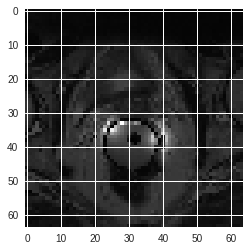

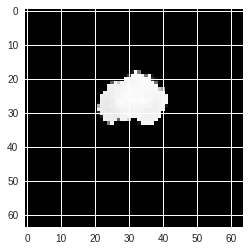

In [42]:
# specify these to plot the results w.r.t. the images
step = 10500  
idx_case = 29
idx_slice = 9

image = np.load(os.path.join(path_to_data, "image_test%02d.npy" % idx_case))[::2, ::2, ::2]
label = np.load("label_test%02d_step%06d.npy" % (idx_case, step))[..., 0]
print(label.shape)
plt.figure()
plt.imshow(image[idx_slice,:,:], cmap='gray')
plt.figure()
plt.imshow(label[idx_slice,:,:], cmap='gray')

- If running on Colab, download the saved data:

```python
from google.colab import files

files.download("label_test%02d_step%06d.npy" % (idx_case, step))
```

In [0]:
from google.colab import files

files.download("label_test%02d_step%06d.npy" % (idx_case, step))